# Facial Expression Recognition - All in One

In [ ]:
#erh

In [1]:

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt
import threading
from flask import Flask, request, jsonify
from PIL import Image
import io

In [ ]:

data_dir = "fer2013"
batch_size = 32
image_size = 224

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# تحميل البيانات
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=transform)

# اختيار عينات عشوائية من التدريب
from torch.utils.data import Subset
from collections import defaultdict
import random

indices_per_class = defaultdict(list)
for idx, (_, label) in enumerate(full_train_dataset):
    indices_per_class[label].append(idx)

samples_per_class = 300  # عدد الصور من كل فئة
balanced_indices = []
for label, indices in indices_per_class.items():
    random.shuffle(indices)
    balanced_indices.extend(indices[:samples_per_class])

train_dataset = Subset(full_train_dataset, balanced_indices)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# أسماء الفئات
class_names = full_train_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from collections import Counter
#التحقق من عدد الصور المستخدمة في التدريب لكل فئة
labels = [label for _, label in train_dataset]
print(Counter(labels))
print("Class names: ", class_names)

Counter({0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300})
Class names:  ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [5]:
import os
from collections import defaultdict

data_dir = "fer2013/train"
class_counts = defaultdict(int)

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len([f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        class_counts[class_name] = num_images

#التأكد من امكانية الوصول الى ال dataset الاصلية
print("عدد الصور في كل فئة:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} صورة")

عدد الصور في كل فئة:
angry: 3995 صورة
disgust: 436 صورة
fear: 4097 صورة
happy: 7215 صورة
neutral: 4965 صورة
sad: 4830 صورة
surprise: 3171 صورة


In [6]:
# (ResNet18) استخدام النموذج
import time

model = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# تدريب النموذج
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%, Time: {time.time() - start_time:.2f}s")

    # تقييم على بيانات التحقق
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total
    print(f"Validation Accuracy: {val_acc:.2f}%")

# حفظ النموذج
torch.save(model, "fer_model.pth")

Epoch 1/10, Loss: 1.8884, Accuracy: 23.71%, Time: 287.97s
Validation Accuracy: 24.37%
Epoch 2/10, Loss: 1.5590, Accuracy: 42.24%, Time: 280.10s
Validation Accuracy: 35.05%
Epoch 3/10, Loss: 1.2356, Accuracy: 57.05%, Time: 280.58s
Validation Accuracy: 43.80%
Epoch 4/10, Loss: 0.9055, Accuracy: 73.52%, Time: 280.34s
Validation Accuracy: 42.88%
Epoch 5/10, Loss: 0.6137, Accuracy: 84.00%, Time: 280.69s
Validation Accuracy: 43.37%
Epoch 6/10, Loss: 0.3623, Accuracy: 94.62%, Time: 280.52s
Validation Accuracy: 45.17%
Epoch 7/10, Loss: 0.1969, Accuracy: 98.52%, Time: 279.47s
Validation Accuracy: 45.85%
Epoch 8/10, Loss: 0.1138, Accuracy: 99.71%, Time: 281.00s
Validation Accuracy: 46.09%
Epoch 9/10, Loss: 0.0714, Accuracy: 99.95%, Time: 278.08s
Validation Accuracy: 46.20%
Epoch 10/10, Loss: 0.0515, Accuracy: 99.95%, Time: 277.39s
Validation Accuracy: 46.18%


In [7]:
#اختبار النموذج 1
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image

data_transforms = {
    'val': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.ToTensor(),
        transforms.Normalize([0.5],[0.5],[0.5])
    ])
}

img_path = 'Training_680349.jpg'
img = Image.open(img_path).convert('RGB')
img = data_transforms['val'](img)
img = img.unsqueeze(0)
img = img.to(device)

model.eval()
with torch.no_grad():
    outputs = model(img)
    _, preds = torch.max(outputs, 1)
    print(f'Predicted: {class_names[preds[0]]}')
    
#     ax = plt.subplot(2,2,1)
#     ax.axis('off')

Predicted: disgust


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9529412].


عدد الصور في كل فئة:
angry: 300 صورة
disgust: 300 صورة
fear: 300 صورة
happy: 300 صورة
neutral: 300 صورة
sad: 300 صورة
surprise: 300 صورة


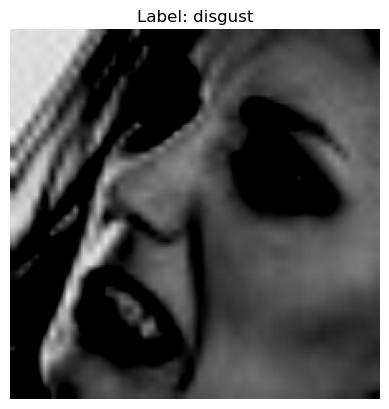

تنبؤ النموذج: disgust


In [8]:
#اختبار النموذج 2
import matplotlib.pyplot as plt
import random
from collections import Counter

# 1. عرض عدد الصور في كل فئة
labels = [label for _, label in train_dataset]
label_counts = Counter(labels)
print("عدد الصور في كل فئة:")
for idx, count in label_counts.items():
    print(f"{class_names[idx]}: {count} صورة")

# 2. اختيار صورة عشوائية من بيانات التدريب
idx = random.randint(0, len(train_dataset) - 1)
img, label = train_dataset[idx]

# عرض الصورة
plt.imshow(img.permute(1, 2, 0))  # تحويل التنسور إلى الشكل المناسب للعرض
plt.title(f"Label: {class_names[label]}")
plt.axis('off')
plt.show()

# 3. تمرير الصورة إلى النموذج
model.eval()
img_input = img.unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_input)
    _, predicted = torch.max(outputs, 1)

print(f"تنبؤ النموذج: {class_names[predicted.item()]}")